# 02 - Treinamento e Avaliação de Modelos

**Objetivo:** Este notebook utiliza o conhecimento da análise exploratória para treinar, avaliar e comparar diferentes modelos de Machine Learning, com o objetivo de encontrar o classificador mais preciso e robusto para o nosso problema.

**Etapas:**
1.  **Configuração e Preparação dos Dados**: Carrega os dados e aplica a engenharia de features desenvolvida no notebook anterior.
2.  **Divisão de Dados**: Separa os dados em conjuntos de treino e teste para uma avaliação imparcial.
3.  **Seleção de Features**: Define um subconjunto de features para treinar um modelo mais simples e eficiente.
4.  **Divisão de Dados**: Separa os dados em conjuntos de treino e teste para uma avaliação imparcial.
5.  **Modelo de Base (Gaussian Naive Bayes)**: Treina e avalia o modelo atual para estabelecer uma linha de base de performance.
6.  **Experimentação com Modelos Avançados**: Treina e avalia `Random Forest` e `LightGBM` para buscar uma performance superior.
7.  **Comparação e Seleção**: Compara a performance de todos os modelos usando validação cruzada para escolher o melhor.
8.  **Análise de Importância das Features**: Investiga quais features mais contribuíram para a decisão do melhor modelo.
9.  **Treinamento e Exportação do Modelo Final**: Treina o modelo `GaussianNB` com todos os dados e o exporta no formato correto para uso no dashboard.

In [1]:
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, skew
from sqlalchemy import create_engine

# Modelos e Ferramentas de Avaliação
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# --- CONFIGURAÇÕES ---

# Conexão com o banco de dados
DB_CONNECTION_STR = 'mysql+mysqlconnector://root:@localhost/iot_mpu6050'

# Parâmetros da Engenharia de Features
WINDOW_SIZE = 100  # Tamanho da janela deslizante
STEP = 20          # Passo da janela

# Diretório para salvar o modelo treinado
PATH_MODELS = 'output/models/'
os.makedirs(PATH_MODELS, exist_ok=True)

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

print("Ambiente configurado com sucesso!")

Ambiente configurado com sucesso!


In [2]:
# Esta funcao e a mesma do notebook 01_Analise_Exploratoria
# CORRECAO CRITICA: ddof=0 (populacional) para alinhar com JavaScript e Notebook 01

def extract_time_domain_features(series):
    """Calcula um conjunto de features de dominio do tempo para uma serie de dados.
    IMPORTANTE: std usa ddof=0 (populacional) para alinhar com o dashboard JS."""
    series = series.dropna()
    if series.empty:
        return pd.Series(dtype='float64')

    arr = series.values.astype(np.float64)

    mean = np.mean(arr)
    std = np.std(arr, ddof=0)  # CORRIGIDO: ddof=0 (era ddof=1 via pandas default)

    rms = np.sqrt(np.mean(arr**2))
    peak = np.max(np.abs(arr))
    root_amplitude = (np.mean(np.sqrt(np.abs(arr))))**2
    mean_abs = np.mean(np.abs(arr))

    crest_factor = peak / rms if rms > 1e-10 else 0
    shape_factor = rms / mean_abs if mean_abs > 1e-10 else 0
    impulse_factor = peak / mean_abs if mean_abs > 1e-10 else 0
    clearance_factor = peak / root_amplitude if root_amplitude > 1e-10 else 0

    return pd.Series({
        'mean': mean,
        'std': std,
        'skew': float(skew(arr, bias=True)),
        'kurtosis': float(kurtosis(arr, fisher=True, bias=True)),
        'rms': rms,
        'peak': peak,
        'root_amplitude': root_amplitude,
        'crest_factor': crest_factor,
        'shape_factor': shape_factor,
        'impulse_factor': impulse_factor,
        'clearance_factor': clearance_factor
    })

print("Funcao extract_time_domain_features definida (ddof=0 - alinhado com JS).")

Funcao extract_time_domain_features definida (ddof=0 - alinhado com JS).


In [3]:
print("--- [1/9] Carregando e Processando Dados ---")

# 1. Carregar dados do banco
try:
    engine = create_engine(DB_CONNECTION_STR)
    query = "SELECT * FROM sensor_data WHERE fan_state IN ('LOW', 'MEDIUM', 'HIGH') ORDER BY timestamp ASC"
    df_raw = pd.read_sql(query, engine)
    print(f"✅ Dados brutos carregados: {len(df_raw)} linhas.")
except Exception as e:
    print(f"❌ ERRO AO CARREGAR DADOS: {e}")
    df_raw = pd.DataFrame()

# 2. Aplicar Engenharia de Features (Janela Deslizante)
all_window_features = []
if not df_raw.empty:
    sensor_axes = ['accel_x_g', 'accel_y_g', 'accel_z_g', 'gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']
    
    for state in df_raw['fan_state'].unique():
        df_state = df_raw[df_raw['fan_state'] == state].reset_index(drop=True)
        if len(df_state) < WINDOW_SIZE:
            continue
        
        print(f'Processando classe "{state}"...')
        for i in range(0, len(df_state) - WINDOW_SIZE + 1, STEP):
            window = df_state.iloc[i : i + WINDOW_SIZE]
            
            features_for_window = {'fan_state': state}
            for axis in sensor_axes:
                features_for_axis = extract_time_domain_features(window[axis])
                for feature_name, value in features_for_axis.items():
                    features_for_window[f'{axis}_{feature_name}'] = value
            
            all_window_features.append(features_for_window)

    df_features = pd.DataFrame(all_window_features)
    print(f"\n✅ Dataset de Features Criado: {df_features.shape[0]} amostras, {df_features.shape[1]-1} features.")
    display(df_features.head())
else:
    df_features = pd.DataFrame()
    print("Nenhum dado para processar.")

--- [1/9] Carregando e Processando Dados ---
✅ Dados brutos carregados: 7710 linhas.
Processando classe "LOW"...
Processando classe "MEDIUM"...
Processando classe "HIGH"...

✅ Dataset de Features Criado: 372 amostras, 66 features.


,fan_state,accel_x_g_mean,accel_x_g_std,accel_x_g_skew,accel_x_g_kurtosis,accel_x_g_rms,accel_x_g_peak,accel_x_g_root_amplitude,accel_x_g_crest_factor,accel_x_g_shape_factor,...,gyro_z_dps_std,gyro_z_dps_skew,gyro_z_dps_kurtosis,gyro_z_dps_rms,gyro_z_dps_peak,gyro_z_dps_root_amplitude,gyro_z_dps_crest_factor,gyro_z_dps_shape_factor,gyro_z_dps_impulse_factor,gyro_z_dps_clearance_factor
0,LOW,0.285356,0.027907,-0.068259,-0.321807,0.286718,0.354004,0.284667,1.234678,1.004771,...,10.415502,-0.413717,-1.019608,10.922145,19.3511,8.646975,1.771731,1.137651,2.015611,2.237904
1,LOW,0.287319,0.026849,0.050836,-0.459368,0.288571,0.354004,0.286690,1.226748,1.004357,...,11.071891,-0.246634,-1.293031,11.215726,19.3511,9.043573,1.725354,1.123966,1.939240,2.139763
2,LOW,0.285422,0.027083,0.009899,-0.570162,0.286704,0.354004,0.284776,1.234735,1.004492,...,10.562525,0.335504,-1.128496,10.787913,19.3511,8.536140,1.793776,1.136090,2.037891,2.266961
3,LOW,0.284094,0.026789,0.084623,-0.340713,0.285355,0.354004,0.283461,1.240576,1.004436,...,10.429035,-0.111564,-1.240200,10.549717,18.3664,8.269001,1.740938,1.142726,1.989415,2.221115
4,LOW,0.287073,0.026282,0.260189,-0.392598,0.288273,0.354004,0.286475,1.228015,1.004182,...,10.423967,-0.493210,-1.014617,11.114319,18.3664,9.105028,1.652499,1.117214,1.846195,2.017171


In [4]:
print("--- [3/9] Selecao de Features ---")

# CORRIGIDO: Usar as features selecionadas pelo ANOVA do notebook 01
# Antes usava TOP_10 hardcoded (gyro_z_dps_std, etc.) que NAO correspondia ao notebook 01

# Tentar carregar do feature_config.json gerado pelo notebook 01
config_path = os.path.join('..', 'config', 'feature_config.json')
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        feature_config = json.load(f)
    SELECTED_FEATURES = feature_config.get('selected_features', [])
    print(f"Features carregadas do feature_config.json (v{feature_config.get('version', '?')})")
    print(f"Metodo: {feature_config.get('selection_criteria', {}).get('method', '?')}")
else:
    # Fallback: 14 features ANOVA selecionadas pelo notebook 01 (2026-01-31)
    SELECTED_FEATURES = [
        'gyro_z_dps_peak',
        'gyro_y_dps_skew',
        'accel_x_g_skew',
        'accel_z_g_skew',
        'accel_x_g_kurtosis',
        'gyro_x_dps_shape_factor',
        'gyro_y_dps_kurtosis',
        'gyro_y_dps_shape_factor',
        'accel_x_g_root_amplitude',
        'accel_z_g_kurtosis',
        'accel_y_g_skew',
        'accel_x_g_mean',
        'accel_z_g_root_amplitude',
        'gyro_x_dps_kurtosis',
    ]
    print("feature_config.json nao encontrado, usando fallback (14 features ANOVA).")

print(f"\nUsando {len(SELECTED_FEATURES)} features selecionadas:")
for i, f in enumerate(SELECTED_FEATURES, 1):
    print(f"  {i:2d}. {f}")

--- [3/9] Selecao de Features ---
Features carregadas do feature_config.json (v3.0)
Metodo: anova_f_test_with_correlation_filter

Usando 14 features selecionadas:
   1. gyro_z_dps_peak
   2. gyro_y_dps_skew
   3. accel_x_g_skew
   4. accel_z_g_skew
   5. accel_x_g_kurtosis
   6. gyro_x_dps_shape_factor
   7. gyro_y_dps_kurtosis
   8. gyro_y_dps_shape_factor
   9. accel_x_g_root_amplitude
  10. accel_z_g_kurtosis
  11. accel_y_g_skew
  12. accel_x_g_mean
  13. accel_z_g_root_amplitude
  14. gyro_x_dps_kurtosis


In [5]:
print("--- [4/9] Dividindo Dados em Treino e Teste ---")

if not df_features.empty:
    # Separa as features (X) do rótulo (y)
    X = df_features.drop('fan_state', axis=1)
    y = df_features['fan_state']
    
    # Aplica a seleção de features se a lista estiver preenchida
    if SELECTED_FEATURES:
        # Garante que todas as features selecionadas existem no DataFrame
        existing_selected_features = [f for f in SELECTED_FEATURES if f in X.columns]
        if len(existing_selected_features) != len(SELECTED_FEATURES):
            print("⚠️ Aviso: Algumas features selecionadas não foram encontradas no DataFrame gerado.")
        
        X = X[existing_selected_features]
        print(f"\nDataset filtrado para {X.shape[1]} features.")

    # Converte rótulos de texto para números (ex: 'LOW' -> 0), necessário para alguns modelos
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Divide os dados (80% para treino, 20% para teste)
    # stratify=y garante que a proporção de classes seja a mesma nos dois conjuntos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print(f"Tamanho do conjunto de treino: {len(X_train)}")
    print(f"Tamanho do conjunto de teste:  {len(X_test)}")
    print(f"Classes: {label_encoder.classes_}")
else:
    print("DataFrame de features vazio. Não é possível dividir os dados.")

--- [4/9] Dividindo Dados em Treino e Teste ---

Dataset filtrado para 14 features.
Tamanho do conjunto de treino: 297
Tamanho do conjunto de teste:  75
Classes: ['HIGH' 'LOW' 'MEDIUM']


In [6]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plota uma matriz de confusão visualmente clara."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão', fontsize=16)
    plt.ylabel('Classe Verdadeira', fontsize=12)
    plt.xlabel('Classe Prevista', fontsize=12)
    plt.show()

def evaluate_model(model, X_test, y_test, class_names):
    """Faz previsões, calcula métricas e plota a matriz de confusão."""
    print(f"--- Avaliando Modelo: {model.__class__.__name__} ---")
    
    # Faz previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Calcula a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia no Teste: {accuracy * 100:.2f}%\n")
    
    # Mostra o relatório de classificação (precisão, recall, f1-score)
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Plota a matriz de confusão
    plot_confusion_matrix(y_test, y_pred, class_names)

print("Funções auxiliares de avaliação definidas.")

Funções auxiliares de avaliação definidas.


--- [5/9] Treinando e Avaliando o Modelo de Base ---
--- Avaliando Modelo: GaussianNB ---
Acurácia no Teste: 100.00%

Relatório de Classificação:
              precision    recall  f1-score   support

        HIGH       1.00      1.00      1.00        25
         LOW       1.00      1.00      1.00        26
      MEDIUM       1.00      1.00      1.00        24

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



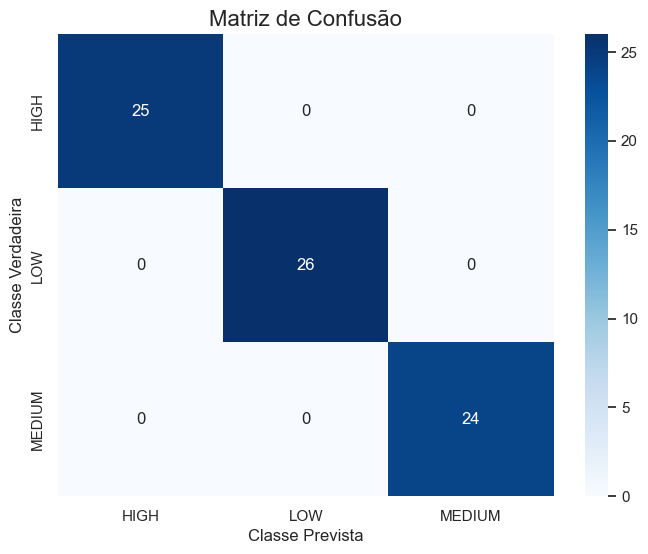

In [7]:
print("--- [5/9] Treinando e Avaliando o Modelo de Base ---")

if 'X_train' in locals():
    # Inicializa e treina o modelo
    gnb_model = GaussianNB()
    gnb_model.fit(X_train, y_train)

    # Avalia o modelo
    evaluate_model(gnb_model, X_test, y_test, label_encoder.classes_)
else:
    print("Conjunto de treino não definido.")

--- [6/9] Treinando e Avaliando o Modelo Random Forest ---
--- Avaliando Modelo: RandomForestClassifier ---
Acurácia no Teste: 100.00%

Relatório de Classificação:
              precision    recall  f1-score   support

        HIGH       1.00      1.00      1.00        25
         LOW       1.00      1.00      1.00        26
      MEDIUM       1.00      1.00      1.00        24

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



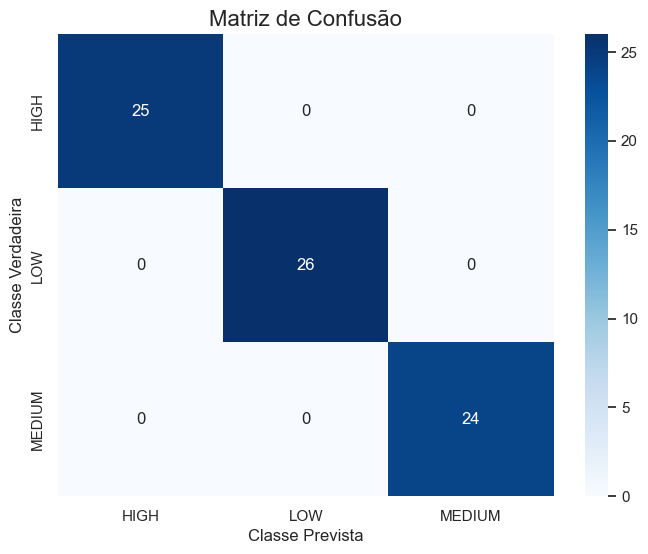

In [8]:
print("--- [6/9] Treinando e Avaliando o Modelo Random Forest ---")

if 'X_train' in locals():
    # Inicializa e treina o modelo
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)

    # Avalia o modelo
    evaluate_model(rf_model, X_test, y_test, label_encoder.classes_)
else:
    print("Conjunto de treino não definido.")

--- [6/9] Treinando e Avaliando o Modelo LightGBM ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1375
[LightGBM] [Info] Number of data points in the train set: 297, number of used features: 14
[LightGBM] [Info] Start training from score -1.129384
[LightGBM] [Info] Start training from score -1.049341
[LightGBM] [Info] Start training from score -1.119021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\Anderson\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Anderson\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Anderson\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Anderson\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, pre

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
--- Avaliando Modelo: LGBMClassifier ---
Acurácia no Teste: 100.00%

Relatório de Classificação:
              precision    recall  f1-score   support

        HIGH       1.00      1.00      1.00        25
         LOW       1.00      1.00      1.00        26
      MEDIUM       1.00      1.00      1.00        24

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



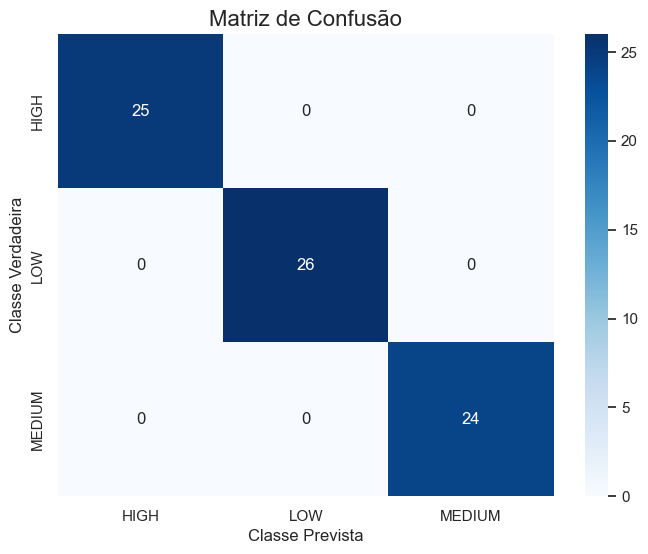

In [9]:
print("--- [6/9] Treinando e Avaliando o Modelo LightGBM ---")

if 'X_train' in locals():
    # Inicializa e treina o modelo
    lgbm_model = lgb.LGBMClassifier(random_state=42)
    lgbm_model.fit(X_train, y_train)

    # Avalia o modelo
    evaluate_model(lgbm_model, X_test, y_test, label_encoder.classes_)
else:
    print("Conjunto de treino não definido.")

--- [7/9] Comparando Modelos com Validação Cruzada ---
Acurácia Média (CV) para GaussianNB: 100.00%
Acurácia Média (CV) para RandomForest: 100.00%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 297, number of used features: 14
[LightGBM] [Info] Start training from score -1.119021
[LightGBM] [Info] Start training from score -1.049341
[LightGBM] [Info] Start training from score -1.129384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

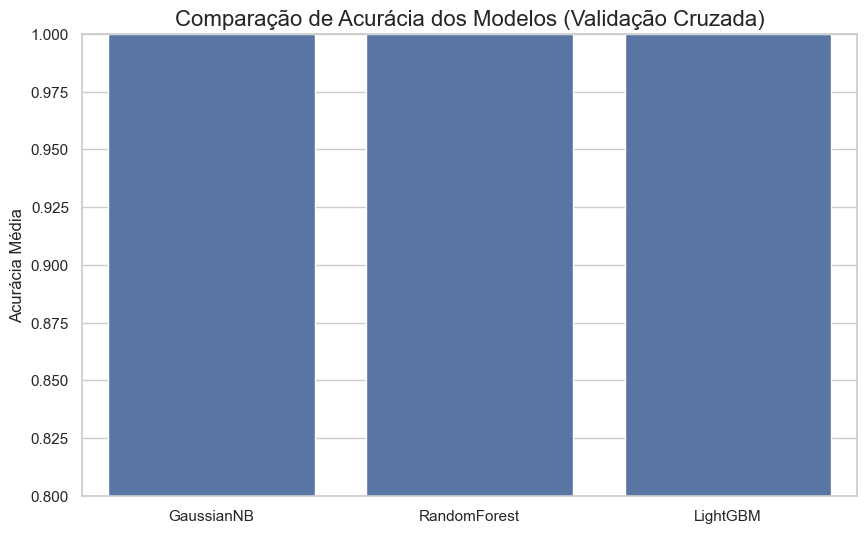

In [10]:
print("--- [7/9] Comparando Modelos com Validação Cruzada ---")

if 'X' in locals():
    models = {
        'GaussianNB': GaussianNB(),
        'RandomForest': RandomForestClassifier(random_state=42),
        'LightGBM': lgb.LGBMClassifier(random_state=42)
    }

    results = {}
    for name, model in models.items():
        # cv=5 significa que os dados serão divididos 5 vezes
        scores = cross_val_score(model, X, y_encoded, cv=5, scoring='accuracy')
        results[name] = scores.mean()
        print(f"Acurácia Média (CV) para {name}: {results[name] * 100:.2f}%")

    # Plotar comparação
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(results.keys()), y=list(results.values()))
    plt.title('Comparação de Acurácia dos Modelos (Validação Cruzada)', fontsize=16)
    plt.ylabel('Acurácia Média', fontsize=12)
    plt.ylim(0.8, 1.0)
    plt.show()
else:
    print("Dataset completo não definido.")

--- [8/9] Analisando a Importância das Features ---


C:\Users\Anderson\AppData\Local\Temp\ipykernel_35768\1920995887.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


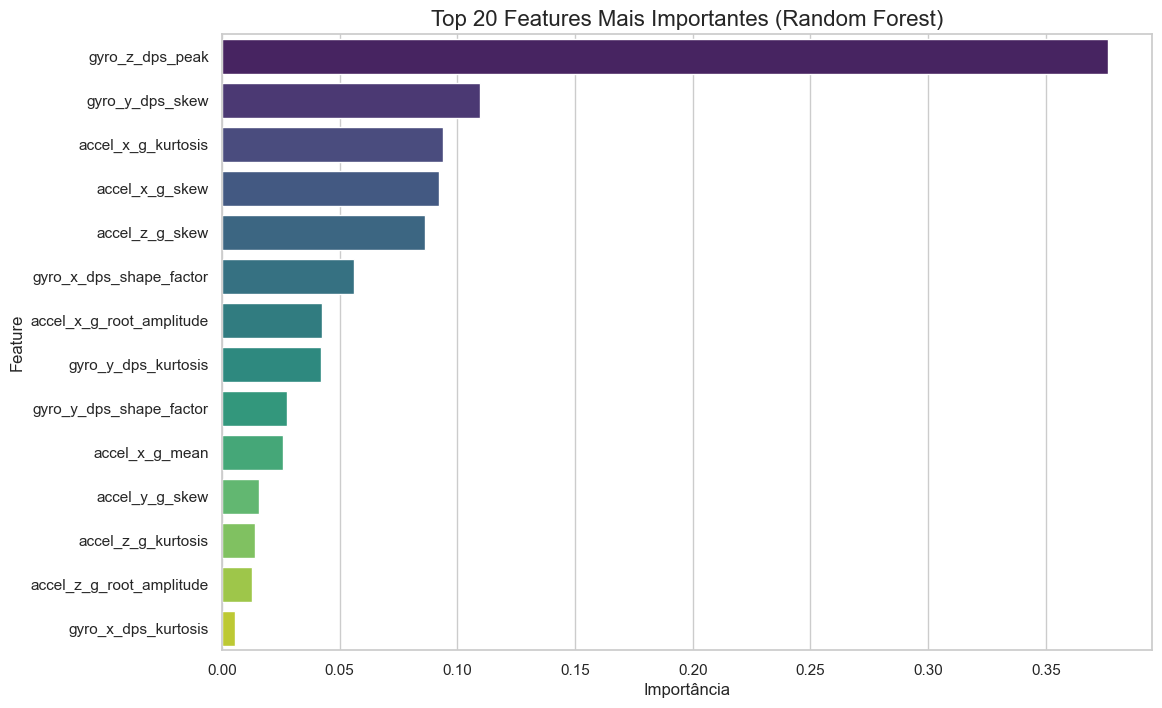

In [11]:
print("--- [8/9] Analisando a Importância das Features ---")

# Usaremos o modelo Random Forest, que já foi treinado, para esta análise
if 'rf_model' in locals():
    importances = rf_model.feature_importances_
    feature_names = X.columns
    
    # Cria um DataFrame para facilitar a ordenação e plotagem
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Plota as 20 features mais importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
    plt.title('Top 20 Features Mais Importantes (Random Forest)', fontsize=16)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()
else:
    print("Modelo Random Forest não foi treinado.")

In [12]:
print("--- [9/9] Treinando e Exportando o Modelo Final para o Dashboard ---")

def export_gaussian_nb_model(model, features, labels, output_path):
    """Exporta um modelo GaussianNB treinado no formato JSON compatível com o classifier.js"""
    
    # Calcula métricas finais
    train_acc = accuracy_score(y_encoded, model.predict(X))
    cv_scores = cross_val_score(model, X, y_encoded, cv=5)
    
    export_data = {
        "type": "gaussian_nb",
        "version": f"py_{time.strftime('%Y%m%d')}",
        "generated_at": time.strftime("%Y-%m-%d %H:%M:%S"),
        "features": features,
        "labels": list(labels),
        "priors": {},
        "stats": {},
        "metrics": {
            "train_accuracy": train_acc,
            "cv_accuracy_mean": cv_scores.mean()
        },
        "training_info": {
            "total_samples": len(X),
            "window_size": WINDOW_SIZE
        }
    }

    # Preenche Priors
    if hasattr(model, 'class_prior_'):
        priors = model.class_prior_
    else:
        priors = model.class_count_ / model.class_count_.sum()
        
    for i, label in enumerate(labels):
        export_data["priors"][label] = priors[i]
        
    # Preenche Stats (Médias e Variâncias)
    # Estrutura: stats[LABEL][FEATURE] = { mean: ..., var: ... }
    for i, label in enumerate(labels):
        export_data["stats"][label] = {}
        for j, feature in enumerate(features):
            export_data["stats"][label][feature] = {
                "mean": model.theta_[i, j],
                "var": model.var_[i, j]
            }
            
    # Salva o arquivo
    with open(output_path, 'w') as f:
        json.dump(export_data, f, indent=2)
    print(f"✅ Modelo exportado com sucesso para: {os.path.abspath(output_path)}")


if 'X' in locals():
    # NOTA: Embora Random Forest seja provavelmente melhor, o frontend atual só suporta GaussianNB.
    # Portanto, vamos treinar o GNB com todos os dados e exportá-lo.
    print("Treinando modelo GaussianNB final com todos os dados...")
    final_gnb_model = GaussianNB()
    final_gnb_model.fit(X, y_encoded)
    
    # Define o nome do arquivo de saída
    output_filename = f"gnb_model_{time.strftime('%Y%m%d')}.json"
    output_filepath = os.path.join(PATH_MODELS, output_filename)
    
    # Exporta o modelo
    export_gaussian_nb_model(final_gnb_model, list(X.columns), label_encoder.classes_, output_filepath)
    
    print("\n--- Próximos Passos ---")
    print("1. O novo modelo foi salvo na pasta 'output/models/'.")
    print("2. Copie este arquivo para a pasta 'models/' na raiz do projeto.")
    print(f"3. Atualize a constante 'MODEL_URL' no arquivo 'js/dashboard.js' para: 'models/{output_filename}'")

else:
    print("Dataset não foi criado. Não é possível treinar ou exportar o modelo.")

--- [9/9] Treinando e Exportando o Modelo Final para o Dashboard ---
Treinando modelo GaussianNB final com todos os dados...
✅ Modelo exportado com sucesso para: c:\xampp\htdocs\XAMPP_iot_mpu_6050\notebooks\output\models\gnb_model_20260131.json

--- Próximos Passos ---
1. O novo modelo foi salvo na pasta 'output/models/'.
2. Copie este arquivo para a pasta 'models/' na raiz do projeto.
3. Atualize a constante 'MODEL_URL' no arquivo 'js/dashboard.js' para: 'models/gnb_model_20260131.json'
